# ML to find radial velocities using GALAXIA sim

In [1]:
%matplotlib inline


import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec
from scipy.stats import norm

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
data = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/processed_stars_reshuffled_with_pos_vel.npy')

In [3]:
data_cols = ['source_id', 'l', 'b', 'ra', 'dec', 'parallax', 'parallax_error', 
             'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity',
             'photo_g_mean_mag', 'photo_bp_mean_mag', 'photo_rp_mean_mag',
             'x','y','z','vx','vy','vz','r','phi','theta','vr','vphi','vtheta']
#could train on radial_velocity_error

In [4]:
data = pd.DataFrame(data, columns=data_cols)

In [5]:
data.shape

(75185000, 27)

In [6]:
data.head()


,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,...,z,vx,vy,vz,r,phi,theta,vr,vphi,vtheta
0,5.061412e+17,131.353790,-3.668921,28.938131,58.147300,0.558357,0.025379,-2.61794,0.017121,-0.673081,...,-0.099606,59.186430,214.909786,-0.599243,9.278926,171.686082,90.615062,-27.481188,-221.209388,0.894295
1,4.793522e+17,146.070404,13.149321,74.581562,64.246163,1.284570,0.069426,9.32732,0.038823,-13.126400,...,0.192094,-22.250179,189.906749,6.232524,8.641484,177.192710,88.726251,31.655268,-188.589101,-5.530217
2,5.911549e+18,332.078064,-17.855680,269.959228,-61.602704,0.827003,0.066856,3.33253,0.037386,-6.251980,...,-0.355761,-7.266869,220.743054,-24.071507,7.012840,-175.586689,92.907859,-8.507313,-220.647719,24.534673
3,4.596623e+18,55.180511,24.729351,268.481942,29.790023,0.770408,0.034757,-3.17662,0.020937,-20.357300,...,0.558001,108.587009,160.244402,-19.909387,7.411502,172.474670,85.682199,-87.918403,-173.085269,13.327967
4,4.303083e+18,48.748230,-5.606678,295.265656,11.353417,0.478881,0.022046,-2.53293,0.008481,-5.662840,...,-0.189015,87.723856,233.675764,-2.739426,6.813941,166.738898,91.589557,-31.693813,-247.567647,3.619987


In [7]:
#data = data.drop(data[data.AccretedLabel > 0.0].index)

indices_to_drop = np.load('data_indices_error_lt100_50k.npy')
print(np.shape(indices_to_drop))
print(indices_to_drop[1:10])

data = data.drop(data.index[indices_to_drop])

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

Remove 62,035 stars labeled as accreted:

In [9]:
#data = data.drop(data[data.radial_velocity > 100.0].index)

Remove 484569 stars with radial velocity greater than 100:

In [10]:
#data = data.drop(data[data.radial_velocity < -100.0].index)

In [11]:
# What columns to use?
use_cols = ['l', 'b','parallax','pmra','pmdec']
# Make the design matrix
X = data[use_cols].values
Y = (data['radial_velocity']).values
#Y = (Y - np.mean(Y))/(np.std(Y))

In [12]:
print(X.shape)
print(Y.shape)

(75185000, 5)
(75185000,)


I think this is giving me a negative output because it's summing over y_train, which is not the number of stars, but is instead the radial velocities. 

In [13]:
x_train, X_test, Y_train, y_test = train_test_split(X[0:50000], Y[0:50000], #44590
                                                    test_size = 0.2,
                                                    random_state=42)
#0:497448

In [14]:
#np.save('truth_values_nontransformed',np.hstack((X_test,y_test.reshape(-1, 1))))

In [15]:
SS = StandardScaler()
x_train = SS.fit_transform(x_train)
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

#SS_rv = StandardScaler()
#Y_train = SS_rv.fit_transform(Y_train.reshape(-1, 1))
#y_test = SS_rv.transform(y_test.reshape(-1, 1))

In [16]:
Y_train = Y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [17]:
print(np.shape(Y_train))
print(np.shape(y_test))

(40000, 1)
(10000, 1)


In [18]:
X_train = x_train[0:32000,:] #318336
y_train = Y_train[0:32000]
X_val = x_train[32001:40000,:]#397927
y_val = Y_train[32001:40000]
#need to split for validation
y_low = -700
y_high = 700

In [19]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)
print()
print(X_val.shape)
print(y_val.shape)

(32000, 5)
(32000, 1)

(10000, 5)
(10000, 1)

(7999, 5)
(7999, 1)


In [20]:
#trying to add some weights to training data
#might weight the mean, but no weights on confidence model? (something to think about)
vr_real = Y_train
counts, bins = np.histogram(vr_real,bins=np.linspace(-700,700,51))
bin_centers = (bins[1:]+bins[:-1])/2
interp_func  = interp1d(bin_centers,(counts).astype('float'))
inv_weights = interp_func(vr_real)
weights = 1/inv_weights
weights = np.log(weights)
weights = weights - np.min(weights)+1

weights_train = weights[0:32000]
weights_val = weights[32001:40000]

#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(data[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [22]:
from keras import backend as K
from keras import callbacks as callbacks
global index 

In [23]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1]) + 1e-6
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    return K.mean((ARG - PREFACT) * weights)


In [24]:
def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2.0)
    PREFACT = K.log(K.pow(2 * np.pi, -0.5))
    return K.mean((ARG - PREFACT) * weights)


# Two network technique to calculate the error

In [25]:
from keras.layers import Input, Dense, Lambda, Concatenate, Dropout
from keras.models import Model
from keras.utils import plot_model
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [26]:
y_train = np.hstack([y_train, weights_train])
y_val = np.hstack([y_val, weights_val])

In [27]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
inputs = Input(shape=(5,))
MeanEst = (Dense(30, activation='relu'))(inputs)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(30, activation='relu'))(MeanEst)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(10, activation='relu'))(MeanEst)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(10, activation='relu'))(MeanEst)
MeanEst = (Dense(1, activation='linear'))(MeanEst)
MeanModel = Model(inputs=[inputs], outputs=MeanEst)

ConfEst= (Dense(30, activation='relu'))(inputs)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(30, activation='relu'))(ConfEst)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(30, activation='relu'))(ConfEst)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(30, activation='relu'))(ConfEst)
ConfEst= (Dense(1, activation='relu'))(ConfEst)
ConfModel = Model(inputs=[inputs], outputs=ConfEst)
#how can this give me a confidence output? the only thing that appears to define a confidence is the relu
#on the last layer...think about this.
#CombinedSub = Concatenate(axis=-1)([MeanEst, ConfEst])
CombinedSub = Concatenate(axis=-1)([MeanModel(inputs), ConfModel(inputs)])

CombinedModel = Model(inputs=[inputs], outputs=CombinedSub)
#plot_model(CombinedModel,to_file='demo.png',show_shapes=True)

In [28]:
#CombinedModel.save_weights('modelsIterate/TrainingBoth_0000.hdf5')

In [29]:
CombinedModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            1541        input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            3001        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           model_1[1][0]                    
                                                                 model_2[1][0]              

## First training iteration

In [30]:
CheckPoint = ModelCheckpoint('models_GALAXIA/TrainingMean_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger = CSVLogger(filename='logs/training_mean.log', separator=',', append=False)

mycallbacks = [CheckPoint, ES, RLR, CSV_logger]
#mycallbacks = [ES, RLR]

In [31]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks
                 )

Train on 32000 samples, validate on 7999 samples
Epoch 1/1000
32000/32000 [==============================] - 1s 19us/step - loss: 2554.3547 - val_loss: 2936.3181
Epoch 2/1000
32000/32000 [==============================] - 0s 4us/step - loss: 2554.0609 - val_loss: 2936.0715
Epoch 3/1000
32000/32000 [==============================] - 0s 4us/step - loss: 2553.6683 - val_loss: 2935.8169
Epoch 4/1000
32000/32000 [==============================] - 0s 4us/step - loss: 2553.4412 - val_loss: 2935.4946
Epoch 5/1000
32000/32000 [==============================] - 0s 4us/step - loss: 2553.0531 - val_loss: 2935.0171
Epoch 6/1000
32000/32000 [==============================] - 0s 4us/step - loss: 2552.7209 - val_loss: 2934.5044
Epoch 7/1000
32000/32000 [==============================] - 0s 4us/step - loss: 2552.1946 - val_loss: 2933.9275
Epoch 8/1000
32000/32000 [==============================] - 0s 4us/step - loss: 2551.4493 - val_loss: 2933.1775
Epoch 9/1000
32000/32000 [============================

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


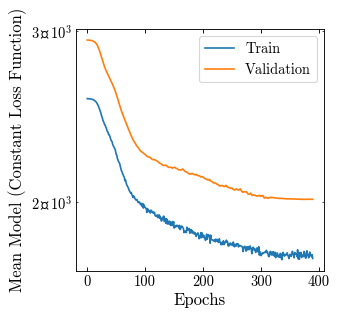

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [33]:
CheckPoint2 = ModelCheckpoint('models_GALAXIA/TrainingErrorBars_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES2 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR2 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger2 = CSVLogger(filename='logs/training_errorbars.log', separator=',', append=False)

mycallbacks2 = [CheckPoint2, ES2, RLR2, CSV_logger2]
#mycallbacks2 = [ES2, RLR2]

In [34]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks2,
                 )

Train on 32000 samples, validate on 7999 samples
Epoch 1/1000
32000/32000 [==============================] - 1s 20us/step - loss: 25751614652416.0000 - val_loss: 126488.1406
Epoch 2/1000
32000/32000 [==============================] - 0s 4us/step - loss: 7853374521344.0000 - val_loss: 81083.3047
Epoch 3/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1275108594688.0000 - val_loss: 64426.9688
Epoch 4/1000
32000/32000 [==============================] - 0s 4us/step - loss: 245419273315.5029 - val_loss: 55335.9805
Epoch 5/1000
32000/32000 [==============================] - 0s 5us/step - loss: 60487820606.9434 - val_loss: 49914.9102
Epoch 6/1000
32000/32000 [==============================] - 0s 4us/step - loss: 355889892969.1902 - val_loss: 46525.1523
Epoch 7/1000
32000/32000 [==============================] - 0s 5us/step - loss: 365567277524.0230 - val_loss: 44288.3750
Epoch 8/1000
32000/32000 [==============================] - 0s 4us/step - loss: 45116.9885 - val_lo

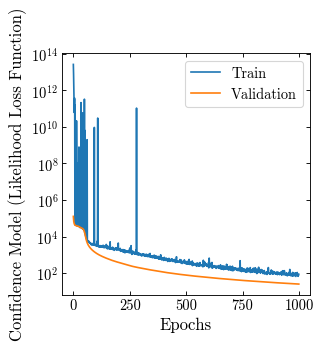

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Second Training Iteration

In [36]:
CheckPoint4 = ModelCheckpoint('models_GALAXIA/TrainingMean2_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES4 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR4 = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger4 = CSVLogger(filename='logs/training_mean2.log', separator=',', append=False)

mycallbacks4 = [CheckPoint4, ES4, RLR4, CSV_logger4]
#mycallbacks4 = [ES4, RLR4]

In [37]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks4
                 )

Train on 32000 samples, validate on 7999 samples
Epoch 1/1000
32000/32000 [==============================] - 1s 17us/step - loss: 1764.5369 - val_loss: 2011.0321
Epoch 2/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1750.4128 - val_loss: 2011.5266
Epoch 3/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1755.5162 - val_loss: 2008.5021
Epoch 4/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1754.4844 - val_loss: 2004.7178
Epoch 5/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1756.0684 - val_loss: 2003.7501
Epoch 6/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1758.1586 - val_loss: 2005.4677
Epoch 7/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1767.9857 - val_loss: 2008.6500
Epoch 8/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1755.9004 - val_loss: 2008.4751
Epoch 9/1000
32000/32000 [============================

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

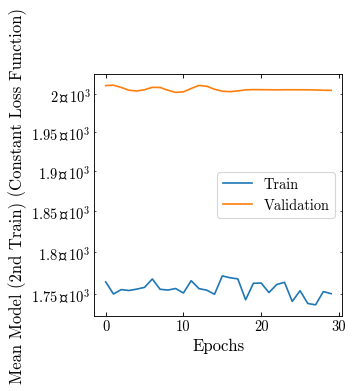

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (2nd Train) (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [39]:
CheckPoint5 = ModelCheckpoint('models_GALAXIA/TrainingErrorBars2_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES5 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR5 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger5 = CSVLogger(filename='logs/training_errorbars2.log', separator=',', append=False)

mycallbacks5 = [CheckPoint5, ES5, RLR5, CSV_logger5]
#mycallbacks5 = [ES5, RLR5]

In [40]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks5,
                 )

Train on 32000 samples, validate on 7999 samples
Epoch 1/1000
32000/32000 [==============================] - 1s 21us/step - loss: 65.6112 - val_loss: 21.4309
Epoch 2/1000
32000/32000 [==============================] - 0s 5us/step - loss: 41.8383 - val_loss: 18.4051
Epoch 3/1000
32000/32000 [==============================] - 0s 5us/step - loss: 39.1324 - val_loss: 16.1396
Epoch 4/1000
32000/32000 [==============================] - 0s 5us/step - loss: 27.2438 - val_loss: 14.5019
Epoch 5/1000
32000/32000 [==============================] - 0s 5us/step - loss: 22.6067 - val_loss: 13.3164
Epoch 6/1000
32000/32000 [==============================] - 0s 5us/step - loss: 19.6714 - val_loss: 12.4534
Epoch 7/1000
32000/32000 [==============================] - 0s 5us/step - loss: 17.6417 - val_loss: 11.8044
Epoch 8/1000
32000/32000 [==============================] - 0s 5us/step - loss: 17.5368 - val_loss: 11.2959
Epoch 9/1000
32000/32000 [==============================] - 0s 5us/step - loss: 14.973

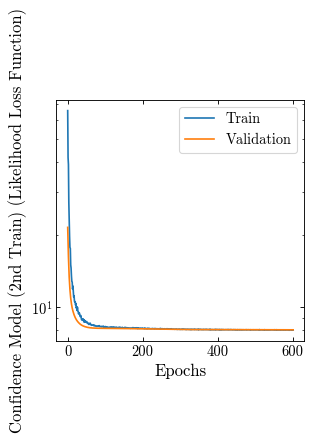

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (2nd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Third Training Iteration

In [42]:
CheckPoint6 = ModelCheckpoint('models_GALAXIA/TrainingMean3_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES4 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR4 = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger6 = CSVLogger(filename='logs/training_mean3.log', separator=',', append=False)

mycallbacks6 = [CheckPoint6, ES4, RLR4, CSV_logger6]
#mycallbacks4 = [ES4, RLR4]

In [43]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks6
                 )

Train on 32000 samples, validate on 7999 samples
Epoch 1/1000
32000/32000 [==============================] - 1s 20us/step - loss: 1748.3493 - val_loss: 2004.2499
Epoch 2/1000
32000/32000 [==============================] - 0s 5us/step - loss: 1761.5228 - val_loss: 2003.5247
Epoch 3/1000
32000/32000 [==============================] - 0s 5us/step - loss: 1763.7800 - val_loss: 2000.1272
Epoch 4/1000
32000/32000 [==============================] - 0s 4us/step - loss: 1748.7073 - val_loss: 2001.5927
Epoch 5/1000
32000/32000 [==============================] - 0s 5us/step - loss: 1761.5844 - val_loss: 2003.8428
Epoch 6/1000
32000/32000 [==============================] - 0s 5us/step - loss: 1768.1500 - val_loss: 2006.8444
Epoch 7/1000
32000/32000 [==============================] - 0s 5us/step - loss: 1750.4924 - val_loss: 2008.9694
Epoch 8/1000
32000/32000 [==============================] - 0s 5us/step - loss: 1755.0981 - val_loss: 2004.7827
Epoch 9/1000
32000/32000 [============================

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

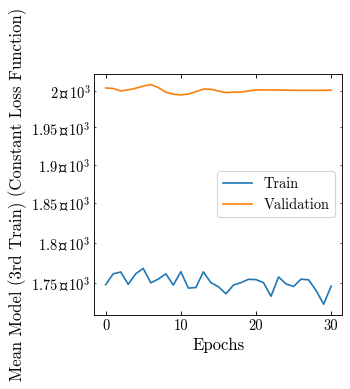

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (3rd Train) (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [45]:
CheckPoint7 = ModelCheckpoint('models_GALAXIA/TrainingErrorBars3_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES5 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR5 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger7 = CSVLogger(filename='logs/training_errorbars3.log', separator=',', append=False)

mycallbacks7 = [CheckPoint7, ES5, RLR5, CSV_logger7]
#mycallbacks5 = [ES5, RLR5]

In [46]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks7,
                 )

Train on 32000 samples, validate on 7999 samples
Epoch 1/1000
32000/32000 [==============================] - 1s 20us/step - loss: 8.0142 - val_loss: 8.0249
Epoch 2/1000
32000/32000 [==============================] - 0s 5us/step - loss: 7.9957 - val_loss: 8.0249
Epoch 3/1000
32000/32000 [==============================] - 0s 5us/step - loss: 7.9966 - val_loss: 8.0234
Epoch 4/1000
32000/32000 [==============================] - 0s 5us/step - loss: 7.9966 - val_loss: 8.0235
Epoch 5/1000
32000/32000 [==============================] - 0s 5us/step - loss: 7.9947 - val_loss: 8.0229
Epoch 6/1000
32000/32000 [==============================] - 0s 5us/step - loss: 7.9951 - val_loss: 8.0231
Epoch 7/1000
32000/32000 [==============================] - 0s 5us/step - loss: 7.9913 - val_loss: 8.0228
Epoch 8/1000
32000/32000 [==============================] - 0s 5us/step - loss: 7.9886 - val_loss: 8.0221
Epoch 9/1000
32000/32000 [==============================] - 0s 5us/step - loss: 7.9784 - val_loss: 8.0

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

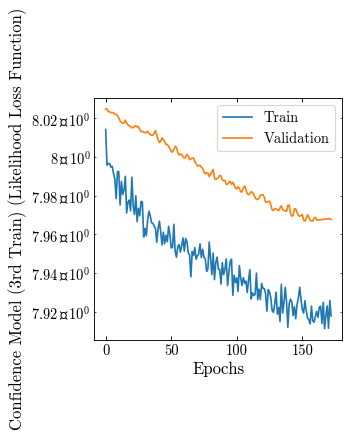

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (3rd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Train Both

In [48]:
CheckPoint3 = ModelCheckpoint('models_GALAXIA/TrainingBoth_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES3 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR3 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger3 = CSVLogger(filename='logs/training_both.log', separator=',', append=False)

mycallbacks3 = [CheckPoint3, ES3, RLR3, CSV_logger3]
#mycallbacks3 = [ES3, RLR3]

In [49]:
ConfModel.trainable = True
MeanModel.trainable = True
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks3,
                 )

Train on 32000 samples, validate on 7999 samples
Epoch 1/1000
32000/32000 [==============================] - 1s 32us/step - loss: 7.9224 - val_loss: 7.9716
Epoch 2/1000
32000/32000 [==============================] - 0s 7us/step - loss: 7.9241 - val_loss: 7.9697
Epoch 3/1000
32000/32000 [==============================] - 0s 6us/step - loss: 7.9155 - val_loss: 7.9708
Epoch 4/1000
32000/32000 [==============================] - 0s 6us/step - loss: 7.9196 - val_loss: 7.9702
Epoch 5/1000
32000/32000 [==============================] - 0s 7us/step - loss: 7.9126 - val_loss: 7.9679
Epoch 6/1000
32000/32000 [==============================] - 0s 7us/step - loss: 7.9114 - val_loss: 7.9673
Epoch 7/1000
32000/32000 [==============================] - 0s 7us/step - loss: 7.9279 - val_loss: 7.9673
Epoch 8/1000
32000/32000 [==============================] - 0s 6us/step - loss: 7.9166 - val_loss: 7.9663
Epoch 9/1000
32000/32000 [==============================] - 0s 6us/step - loss: 7.9172 - val_loss: 7.9

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

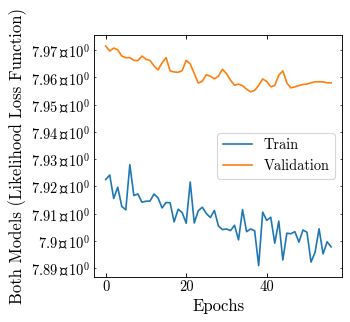

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Both Models (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.savefig('Loss_Plot_Iterate.png')
plt.show()

In [51]:
 def plot_validation(i,type1):   
    y_low = -700
    y_high = 700
    plt.figure(figsize=(12, 12))
    gs0 = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)

    from matplotlib.colors import LogNorm
    plt.subplot(gs0[3])
    plt.hist2d( test_preds[:,1],test_preds[:,0], bins=40,norm = LogNorm())
    clb1 = plt.colorbar()
    clb1.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel('$\sigma$',labelpad=-10)

    plt.subplot(gs0[4])
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb2 = plt.colorbar(sc)
    clb2.set_label('$\sigma$', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.clim(0,750)

    plt.subplot(gs0[2])
    hb = plt.hexbin(y_val[:,0], test_preds[:,0],gridsize=80, norm = LogNorm())
    x1 = np.linspace(np.min(y_val[:,0]),np.max(y_val[:,0]),1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb3 = plt.colorbar(hb)
    clb3.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)


    plt.subplot(gs0[5])
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb4 = plt.colorbar(sc)
    clb4.set_label('$\sigma$\n(saturated)', labelpad=-25, y=1.15, rotation=0,fontsize=10)
    plt.clim(0,200)

    plt.subplot(gs0[6])
    plt.hist2d(X_val[:,2], test_preds[:,1], bins=40, norm = LogNorm())
    clb5 = plt.colorbar()
    clb5.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.xlabel('Distance',fontsize = 12)
    plt.ylabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[1])
    plotrange = np.linspace(-5,5,1000)
    diff_hist = np.divide(np.subtract(test_preds[:,0],y_val[:,0]),test_preds[:,1])
    mean_diffs, mean_stds = np.mean(diff_hist), np.std(diff_hist)
    plt.hist(diff_hist,bins=20, range=(-5,5), histtype='step',color = 'lightseagreen',linewidth = 1.5, density = True)
    plt.plot(plotrange, norm.pdf(plotrange, mean_diffs, mean_stds),color = 'darkorange', linestyle = '--', linewidth = 2.5,label = 'normal fit')
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 8})
    plt.xlabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})/\sigma$',labelpad=-5)
    
    plt.subplot(gs0[7])
    diff_hist_err = np.subtract(test_preds[:,0],y_val[:,0])
    plt.hist2d(test_preds[:,1],diff_hist_err, bins=40,norm = LogNorm())
    clb6 = plt.colorbar()
    clb6.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})$',labelpad=-5)
    plt.xlabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[0])
    plt.hist(y_val[:,0], bins=25, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'val' )
    plt.hist(test_preds[:,0], bins=25, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel(r'$v_{\rm{los}}$', labelpad =-2)
    plt.title('Validation set, Train '+type1+', Epoch '+str(i)+', 20 bins',fontsize=14)
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.savefig('plots'+type1+'/'+'train'+type1+'_'+str(i)+'.png')
    clb1.remove()
    clb2.remove()
    clb3.remove()
    clb4.remove()
    clb5.remove()
    clb6.remove()

#### Plotting First Training

In [52]:
traininmean = [file for file in os.listdir('models_GALAXIA/')
               if file.startswith('TrainingMean_')]
traininmean = sorted(traininmean)[1::10]

In [53]:
%%capture
for i, mfile in enumerate(traininmean):
    CombinedModel.load_weights('models_GALAXIA/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean1');

In [54]:
traininerror = [file for file in os.listdir('models_GALAXIA/')
               if file.startswith('TrainingErrorBars_')]
traininerror = sorted(traininerror)[0::20]

In [55]:
%%capture
for i_err, mfile_err in enumerate(traininerror):
    CombinedModel.load_weights('models_GALAXIA/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error1');

#### Plotting Second Training

In [56]:
traininmean2 = [file for file in os.listdir('models_GALAXIA/')
               if file.startswith('TrainingMean2')]
traininmean2 = sorted(traininmean2)[0::10]

In [57]:
%%capture
for i, mfile in enumerate(traininmean2):
    CombinedModel.load_weights('models_GALAXIA/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean2');

In [58]:
traininerror2 = [file for file in os.listdir('models_GALAXIA/')
               if file.startswith('TrainingErrorBars2')]
traininerror2 = sorted(traininerror2)[0::20]

In [59]:
%%capture
for i_err, mfile_err in enumerate(traininerror2):
    CombinedModel.load_weights('models_GALAXIA/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error2');

#### Plotting Third Training

In [60]:
traininmean3 = [file for file in os.listdir('models_GALAXIA/')
               if file.startswith('TrainingMean3')]
traininmean3 = sorted(traininmean3)[0::10]

In [61]:
%%capture
for i, mfile in enumerate(traininmean3):
    CombinedModel.load_weights('models_GALAXIA/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean3');

In [62]:
traininerror3 = [file for file in os.listdir('models_GALAXIA/')
               if file.startswith('TrainingErrorBars3')]
traininerror3 = sorted(traininerror3)[0::20]

In [63]:
%%capture
for i_err, mfile_err in enumerate(traininerror3):
    CombinedModel.load_weights('models_GALAXIA/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error3');

#### Plot results of training both

In [64]:
traininboth = [file for file in os.listdir('models_GALAXIA/')
               if file.startswith('TrainingBoth')]
traininboth = sorted(traininboth)[1::10]


In [65]:
%%capture
for i_both, mfile_both in enumerate(traininboth):
    CombinedModel.load_weights('models_GALAXIA/' + mfile_both)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_both*10,'Both');

In [66]:
print(np.size(y_test))

10000


### Evaluate the Test Set

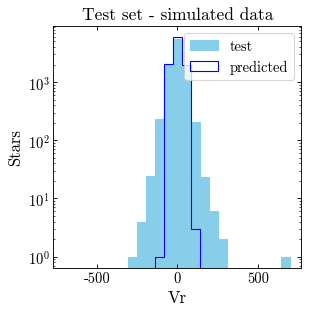

In [67]:
#CombinedModel.load_weights('G_train_2it_50k/models_GALAXIA/' + 'TrainingBoth_0109.hdf5')
test_preds_2 = CombinedModel.predict(X_test)

plt.figure()
plt.hist(y_test, bins=25, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' )
plt.hist(test_preds_2[:,0], bins=25, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.legend(loc = "upper right")
plt.show()

In [ ]:
print(y_high)

## Going to use Monte Carlo simulations to predict errorbars. 

In [ ]:
mc_vr_pred_list = []
bin_values_list = []
min_array = []
max_array = []
mean_array = []
for mc_i in range(0,1000):
    #print(mc_i)
    mc_vr_pred = []
    for star_i in range(0,np.size(y_test)):
        #mc_vr_pred.append(np.mean([np.random.normal(test_preds_2[star_i,0],test_preds_2[star_i,1]) for _ in range(1000)]))
        mc_vr_pred.append(np.random.normal(test_preds_2[star_i,0],test_preds_2[star_i,1]))
    mc_vr_pred_list.append(mc_vr_pred)
    n, bins, patches = plt.hist(mc_vr_pred, bins=20, range=(y_low,y_high), histtype='step')
    plt.xlabel('Vr Monte Carlo')
    plt.yscale('log')
    bin_values_list.append(n)
bin_values_list_arr = np.array(bin_values_list)    
max_array = bin_values_list_arr.max(axis=0)
min_array = bin_values_list_arr.min(axis=0) 
mean_array = bin_values_list_arr.mean(axis=0)
y_error = [min_array,max_array]
print(np.shape(y_error))

In [ ]:
plt.figure()
hist_test, bins_test, patches_test = plt.hist(y_test, bins=20, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' , zorder = 0)
#plt.hist(bins_test[:-1], bins_test, weights=max_array,color = 'green')
#plt.hist(bins_test[:-1], bins_test, weights=min_array,color = 'yellow')
bin_centers_test = (bins_test[1:]+bins_test[:-1])/2
plt.fill_between(bin_centers_test,min_array, max_array,label = 'MC spread',color = 'orange', zorder = 10)

plt.hist(test_preds_2[:,0], bins=20, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted', zorder = 20)
print(y_low,y_high)
plt.xlabel(r'$v_{\rm{los}}$')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.legend(loc = "upper right",prop={'size': 10})
plt.savefig('MC_100trials_8000stars_noavg.png')
plt.show()

In [70]:
 def plot_test():   
    y_low = -700
    y_high = 700
    plt.figure(figsize=(12, 12))
    gs0 = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)

    from matplotlib.colors import LogNorm
    plt.subplot(gs0[3])
    plt.hist2d(test_preds_2[:,1],test_preds_2[:,0], bins=40,norm = LogNorm())
    clb1 = plt.colorbar()
    clb1.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel('$\sigma$',labelpad=-5)
    

    plt.subplot(gs0[4])
    sc = plt.scatter(y_test[:,0], test_preds_2[:,0], c =test_preds_2[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb2 = plt.colorbar(sc)
    clb2.set_label('$\sigma$', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.clim(0,750)

    plt.subplot(gs0[2])
    hb = plt.hexbin(y_test[:,0], test_preds_2[:,0],gridsize=80, norm = LogNorm())
    x1 = np.linspace(np.min(y_test[:,0]),np.max(y_test[:,0]),1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb3 = plt.colorbar(hb)
    clb3.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)


    plt.subplot(gs0[5])
    sc = plt.scatter(y_test[:,0], test_preds_2[:,0], c =test_preds_2[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb4 = plt.colorbar(sc)
    clb4.set_label('$\sigma$\n(saturated)', labelpad=-25, y=1.15, rotation=0,fontsize=10)
    plt.clim(0,200)

    plt.subplot(gs0[6])
    plt.hist2d(X_test[:,2], test_preds_2[:,1], bins=40, norm = LogNorm())
    clb5 = plt.colorbar()
    clb5.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.xlabel('Distance',fontsize = 12)
    plt.ylabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[1])
    plotrange = np.linspace(-5,5,1000)
    diff_hist = np.divide(np.subtract(test_preds_2[:,0],y_test[:,0]),test_preds_2[:,1])
    mean_diffs, mean_stds = np.mean(diff_hist), np.std(diff_hist)
    plt.hist(diff_hist,bins=20, range=(-5,5), histtype='step',color = 'lightseagreen',linewidth = 1.5, density = True)
    plt.plot(plotrange, norm.pdf(plotrange, mean_diffs, mean_stds),color = 'darkorange', linestyle = '--', linewidth = 2.5,label = 'normal fit')
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 8})
    plt.xlabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})/\sigma$',labelpad=-5)
    
    plt.subplot(gs0[7])
    diff_hist_err = np.subtract(test_preds_2[:,0],y_test[:,0])
    plt.hist2d(test_preds_2[:,1],diff_hist_err, bins=40,norm = LogNorm())
    clb6 = plt.colorbar()
    clb6.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})$',labelpad=-5)
    plt.xlabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[0])
    plt.hist(y_test, bins=25, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' )
    plt.hist(test_preds_2[:,0], bins=25, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel(r'$v_{\rm{los}}$', labelpad =-2)
    plt.title('Test set - simulated data, 20 bins',fontsize=14)
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 10})
    plt.savefig('G_plots_test_3it_50k.png')
    #plt.savefig('plots_error/trainerror_'+str(i)+'.png')
    clb1.remove()
    clb2.remove()
    clb3.remove()
    clb4.remove()
    clb5.remove()
    clb6.remove()

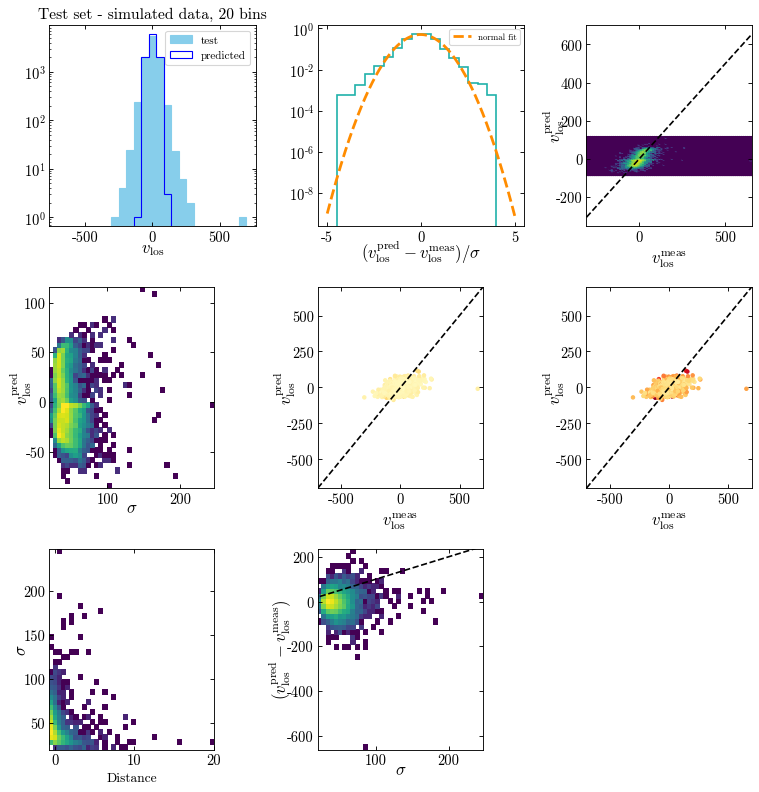

In [71]:
plot_test()

##### Going to try to find original indices of points with low error in train, validation, and test & retrain without those

In [ ]:
print(np.max(test_preds_2[:,1]))

 # min_cl = np.nanmin(code_lengths)
  #  min_k = Ks[code_lengths.index(min_cl)] 
list_pmra_test_err_lt65 = []   
list_rv_test_err_lt65 = [y_test[i,0] for i in range(len(test_preds_2[:,1])) if test_preds_2[i,1] < 90]
print(len(list_rv_test_err_lt65))
#now need indices of these values in data
indices = []
for i in range(len(list_rv_test_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_test_err_lt65[i])].index[0])

In [ ]:
CombinedModel.load_weights('models/' + 'TrainingBoth_0138.hdf5')
test_preds_train = CombinedModel.predict(X_train)

list_rv_train_err_lt65 = [y_train[i,0] for i in range(len(test_preds_train[:,1])) if test_preds_train[i,1] < 90]
for i in range(len(list_rv_train_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_train_err_lt65[i])].index[0])

In [ ]:
test_preds_val = CombinedModel.predict(X_val)

list_rv_val_err_lt65 = [y_val[i,0] for i in range(len(test_preds_val[:,1])) if test_preds_val[i,1] < 90]
for i in range(len(list_rv_val_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_val_err_lt65[i])].index[0])

In [ ]:
np.save('data_indices_error_lt100_50k',indices)

In [ ]:
print(np.shape(indices))